# 라이브러리 불러오기

In [1]:
import glob
import random
import os
from PIL import Image
import sys

import numpy as np
import math
import itertools
import datetime
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable



import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 커스텀 데이터셋 설계

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root, transf = None, unaligned = False, mode = "train"):
        self.transf = transf
        self.unaligned = unaligned
        
        # mode 기준으로 해당 폴더에서 실제 사진과 애니메이션 이미지 불러오기
        if mode == "train":
            # self.files_A,B에 폴더 내부의 모든 이미지의 목록을 리스트로 생성
            self.files_A = sorted(glob.glob(os.path.join(root, "trainA") + "/*.*"))
            self.files_B = sorted(glob.glob(os.path.join(root, "trainB") + "/*.*"))
            
        else:
            self.files_A = sorted(glob.glob(os.path.join(root, "testA") + "/*.*"))
            self.files_B = sorted(glob.glob(os.path.join(root, "testB") + "/*.*"))
            
    def __getitem__(self, index):
        
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned: #학습할 pair를 무작위로 고를지 아니면 fix 시킬지 결정
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
            
        # 불러온 이미지가 흑백 이미지라면 RGB 이미지로 변환
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)
            
        item_A = self.transf(image_A)
        item_B = self.transf(image_B)
        
        return {"A": item_A, "B": item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

# 생성자(Generator) & 판별자(Discriminator) 모델 정의

*Reflection padding은 점대칭 방식으로 가장 가까운 픽셀로부터 값을 복사해옵니다.

Zero Padding처럼 값 지정이 아닌, 더욱 자연스러운 이미지 생성을 위해 사용합니다.



*Instance Normalization은 데이터 개별로 정규화를 진행합니다.

BN은 데이터의 배치 단위로 평균과 분산을 구하여 학습의 안정성을 높이지만,IN은 이미지에 특화된 정규화 과정으로, 이미지를 개별로 정규화합니다.


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace = True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()
        channels = input_shape[0] # channels = 3
        print(channels)
        out_features = 64
        
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7), # 3 -> 64
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace = True),
        ]
        
        in_features = out_features # 64
        
        # Down-Sampling을 2번 진행 + stride = 2로 설정 해놨으므로 이미지의 크기가 절반씩 줄어든다.
        for _ in range(2):
            out_features *= 2 # 128
            model += [
                nn.Conv2d(in_features, out_features, 3, stride = 2, padding = 1), # 64 -> 128
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace = True),
            ]
            in_features = out_features # 128
            #print(in_features)
            
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]
           
        # Upsamplingdmf 2번 진행하여 다시 이미지의 크기를 2배씩 늘린다.
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor = 2),
                nn.Conv2d(in_features, out_features, 3, stride = 1, padding = 1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace = True),
            ]
            in_features = out_features
            
        model += [
            nn.ReflectionPad2d(channels), 
            nn.Conv2d(out_features, channels, 7), 
            nn.Tanh()
        ]
            
        self.model = nn.Sequential(*model)
        
    def forward(self, x): #real_A : ([10, 3, 256, 256])
       # print(x.shape)
        return self.model(x)
    


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        
        # 판별자의 출력은 입력 이미지의 1/16인 Feature Map
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)
        def discriminator_block(in_filters, out_filters, normalize = True):
            # stride = 2로 점점 Downsampling을 진행하며 출력 이미지의 크기를 줄인다.
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride = 2, padding = 1)]
            
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
                
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers
        
        # 입력 이미지의 크기가 256 x 256일 때, discriminator_block을 4번 통과하면 한번 통과할 때마다 크기가 반으로 줄어들기 때문에 
        # 결과적으로 출력 이미지의 크기는 16 x 16이 된다.
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize = False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding = 1)
        )
    def forward(self, img):
        return self.model(img)

# 모델 초기화 및 Hyperparameter 설계

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
        
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

dataset_name = "selfie2anime"
channels, img_height, img_width, n_residual_blocks = 3, 256, 256, 9




n_epochs = 200
init_epoch = 0
decay_epoch = 100
lambda_cyc = 10.0 
lambda_id = 5.0 # labda_id가 클수록 본래의 색감을 유지하려는 성질이 있다.
n_cpu = 8
batch_size = 32
sample_interval = 100
checkpoint_interval = 5

criterion_GAN = torch.nn.MSELoss().to(device)
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)

input_shape = (channels, img_height, img_width)

G_AB = GeneratorResNet(input_shape, n_residual_blocks).to(device) # Style A -> Style B
G_BA = GeneratorResNet(input_shape, n_residual_blocks).to(device) # Style B -> Style A
D_A = Discriminator(input_shape).to(device) # Discriminate the reality of an image as a style of A
D_B = Discriminator(input_shape).to(device) # Discriminate the reality of an image as a style of B

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

lr = 2 * 1e-4

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), 
    lr = lr, betas = (0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr = lr, betas = (0.5, 0.999))





3
3


# 학습 스케쥴러 및 ReplayBuffer 설계


GAN의 경우, seed 값을 다르게 할 때마다 결과가 바뀔 만큼 학습이 불안정 합니다.

아래 그래프상에 존재하는 다양ㅎ나 색깔들은 서로 다른 샘플들을 의미하는데, 파란색 샘플 기준으로 살펴볼 경우, 왼쪽 그래프에서는 Discriminator가 대체로 진짜에 가깝다고 판단하고 있지만,

똑같은 아키텍쳐를 가지고 랜덤시드만 다른게 적용한 오른쪽 그래프에서는 파란색 샘플에 대해 대체적으로 가짜에 가깝다고 판단하고 있습니다.

이러한 문제를 해결하는 방법으로는 판별자를 여러개 생성해서 평균을 내는 방법이 존재하지만, 이 방법은 전체 모델의 크기를 지나치게 키우기 때문에 이미 4개의 모델을 사용하고 있는 CycleGan에는 적절하지 않습니다.

이를 해결하기 위해 Replay buffer, 즉 이전에 Generator가 생성했떤 이미지 히스토리를 일정 개수만큼 저장해두고, 그걸 다시 Discriminator에게 보여줌으로써 전에 봤던 것을 어떻게 반영했는지 알게 해주는 역할을 하는 buffer를 사용하는 것입니다.

이때, Discriminator에 주기적으로 생성된 이미지를 보여줄 때는, Generator에는 Backpropagation과정이 이루어지지않고, Discriminator에게만 이루어지게 하여 Discriminator가 가짜를 더 잘 구분할 수 있도록 합니다.

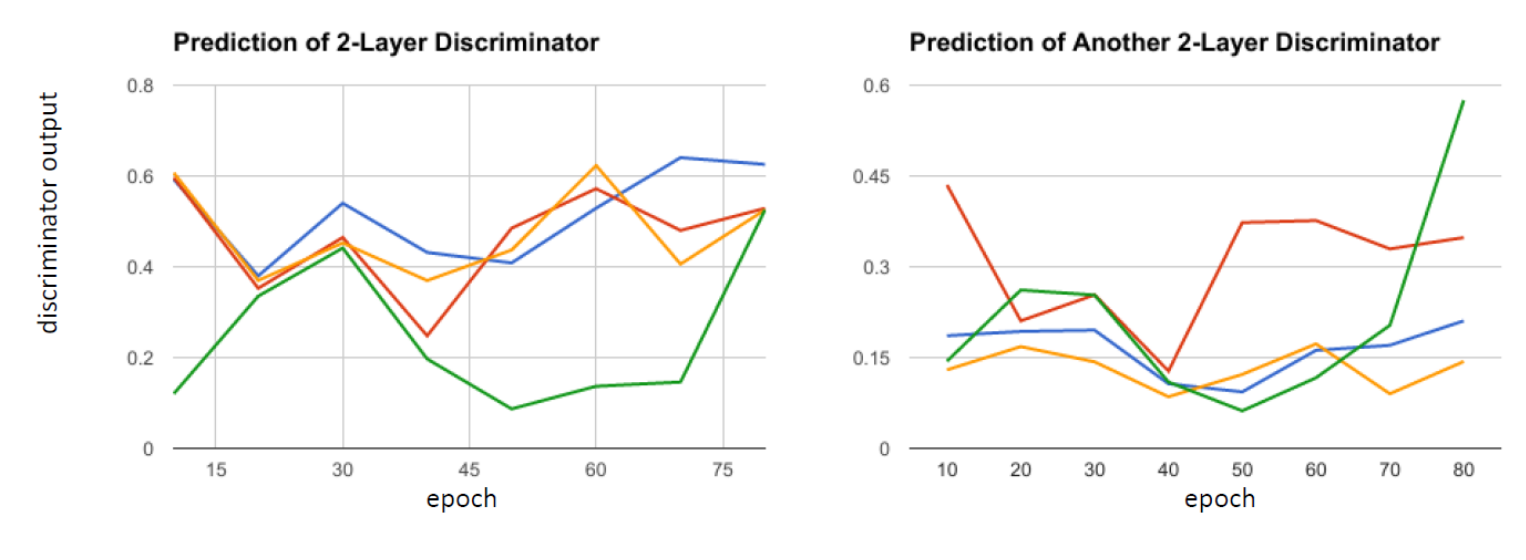

In [5]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    
    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch) 
    
    
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda = LambdaLR(n_epochs, init_epoch, decay_epoch).step
)

class ReplayBuffer:
    def __init__(self, max_size = 50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            
            else:
                to_return.append(element)
        return torch.cat(to_return)
    
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

        



# 샘플 이미지와 모델 가중치를 저장할 폴더 생성 및 시각화하여 저장하는 함수

In [6]:
os.makedirs("images/%s" % dataset_name, exist_ok = True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok = True)

def sample_images(batches_done):
    imgs = next(iter(val_dataloader))
    G_AB.eval() 
    G_BA.eval()
    
    real_A = imgs["A"].to(device)
    fake_B = G_AB(real_A)
    real_B = imgs["B"].to(device)
    fake_A = G_BA(real_B)
    
    real_A = make_grid(real_A, nrow = 5, normalize = True)
    real_B = make_grid(real_B, nrow = 5, normalize = True)   
    fake_A = make_grid(fake_A, nrow = 5, normalize = True)
    fake_B = make_grid(fake_B, nrow = 5, normalize = True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize = False)

# DataLoader 설계

In [7]:
transf = transforms.Compose([
    transforms.Resize(int(img_height * 1.12), Image.Resampling.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = ImageDataset("../input/%s" % dataset_name, transf = transf, unaligned = True)
val_dataset = ImageDataset("../input/%s" % dataset_name, transf = transf, unaligned = True, mode = "test")


train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True)
val_dataloader = DataLoader(train_dataset, batch_size = 5, shuffle = True)




/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [49]:
import torch
torch.cuda.empty_cache()

# 모델 학습

In [ ]:
start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)
        
        real = torch.FloatTensor(real_A.size(0), *D_A.output_shape).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_A.size(0), *D_A.output_shape).fill_(0.0).to(device)
        
        # Generator 학습
        
        G_AB.train()
        G_BA.train()
        optimizer_G.zero_grad()
        
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN Loss
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        loss_GAN_AB = criterion_GAN(D_B(fake_B), real)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), real)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle Consistency Loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # Total Loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
        
        loss_G.backward()
        optimizer_G.step()
        
        # Discriminator A 학습
        
        optimizer_D_A.zero_grad()
        # real 이미지에 대한 판별
        loss_real = criterion_GAN(D_A(real_A), real)
        # fake 이미지에 대한 판별 (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        
        loss_D_A = (loss_real + loss_fake) / 2
        loss_D_A.backward()
        optimizer_D_A.step()
        
        
        # Discriminator B 학습
        
        optimizer_D_B.zero_grad()
        # real 이미지에 대한 판별
        loss_real = criterion_GAN(D_B(real_B), real)
        # fake 이미지에 대한 판별 (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        
        loss_D_B = (loss_real + loss_fake) / 2
        loss_D_B.backward()
        optimizer_D_B.step()
        
        loss_D = (loss_D_A + loss_D_B) / 2
        
        batches_done = epoch * len(train_dataloader) + i
        batches_left = n_epochs * len(train_dataloader) - batches_done
        time_left = datetime.timedelta(seconds = batches_left * (time.time() - start_time))
        
        start_time = time.time()
        
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(train_dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )
        
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
            
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
        torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
        torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
        torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))
        
        

        
        
        
        

[Epoch 0/200] [Batch 155/1700] [D loss: 0.343729] [G loss: 4.524292, adv: 0.473547, cycle: 0.272879, identity: 0.264391] ETA: 3 days, 4:08:41.6017033

In [14]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()         

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=8af0a9e0e24e576e288453297fa38434c8e185164e666ad5e4ca78c1e31d05b9
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM  |
-------------------
|  0 |  0% | 100% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 40% |  2% |
